In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.901371           

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling',
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling',
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        CoExpression           PCC           PPI  Root10DaysSeedling  \
count  41110.000000  41110.000000  41110.000000        41110.000000   
mean       0.991997     -0.361737      0.914668           -0.522040   
std        0.089101      0.463979      0.279379            0.498568   
min        0.000000     -1.000000      0.000000           -1.000000   
25%        1.000000     -0.747963      1.000000           -0.901371   
50%        1.000000     -0.449089      1.000000           -0.663664   
75%        1.000000     -0.051646      1.000000           -0.378497   
max        1.000000      1.000000      1.000000            1.000000   

       Leaf21DaysSeedling  Leaf45DaysOldPlant  log_2FoldChange            ET  \
count        41110.000000        41110.000000     41110.000000  41110.000000   
mean            -0.828778           -0.585144        -0.037332      1.407395   
std              0.327542            0.399046         0.39

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

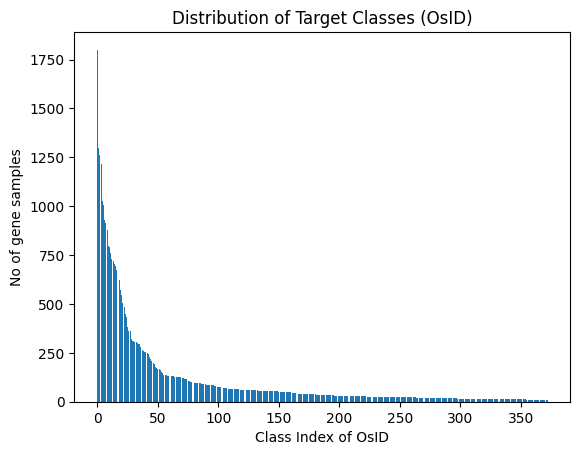

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=120, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Number of input features: 1
Fold: 1
Epoch 1/120
1846/1846 [==============================] - 11s 5ms/step - loss: 5.0790 - accuracy: 0.0409 - val_loss: 5.0241 - val_accuracy: 0.0436
Epoch 2/120
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9619 - accuracy: 0.0440 - val_loss: 5.0183 - val_accuracy: 0.0436
Epoch 3/120
1846/1846 [==============================] - 9s 5ms/step - loss: 4.9546 - accuracy: 0.0440 - val_loss: 5.0153 - val_accuracy: 0.0451
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9516 - accuracy: 0.0454 - val_loss: 5.0226 - val_accuracy: 0.0451
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9497 - accuracy: 0.0454 - val_loss: 5.0184 - val_accuracy: 0.0451
Epoch 6/120
1846/1846 [==============================] - 10s 5ms/step - loss: 4.9480 - accuracy: 0.0454 - val_loss: 5.0151 - val_accuracy: 0.0451
Epoch 7/120
1846/1846 [==============================] - 13s 7ms/step - loss: 4.9470 - accur

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 10s 4ms/step - loss: 5.0500 - accuracy: 0.0485 - val_loss: 4.9785 - val_accuracy: 0.0524
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8841 - accuracy: 0.0520 - val_loss: 4.9295 - val_accuracy: 0.0513
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8467 - accuracy: 0.0567 - val_loss: 4.9111 - val_accuracy: 0.0579
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8224 - accuracy: 0.0571 - val_loss: 4.9137 - val_accuracy: 0.0585
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8027 - accuracy: 0.0603 - val_loss: 4.9024 - val_accuracy: 0.0601
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.7847 - accuracy: 0.0565 - val_loss: 4.8872 - val_accuracy: 0.0513
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.7709 - accuracy: 0.0590 - val_loss: 4.8938 - val_a

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 10s 4ms/step - loss: 4.9332 - accuracy: 0.0683 - val_loss: 4.7811 - val_accuracy: 0.0794
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.6354 - accuracy: 0.0840 - val_loss: 4.7046 - val_accuracy: 0.0781
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5704 - accuracy: 0.0857 - val_loss: 4.6679 - val_accuracy: 0.0748
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5349 - accuracy: 0.0845 - val_loss: 4.6565 - val_accuracy: 0.0752
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5099 - accuracy: 0.0868 - val_loss: 4.6322 - val_accuracy: 0.0785
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.4883 - accuracy: 0.0877 - val_loss: 4.6466 - val_accuracy: 0.0766
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 4.4699 - accuracy: 0.0858 - val_loss: 4.6317 - val_a

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 11s 4ms/step - loss: 4.5732 - accuracy: 0.1082 - val_loss: 4.0977 - val_accuracy: 0.1584
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7113 - accuracy: 0.1918 - val_loss: 3.6165 - val_accuracy: 0.2299
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2702 - accuracy: 0.2612 - val_loss: 3.2137 - val_accuracy: 0.2887
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9040 - accuracy: 0.3082 - val_loss: 2.9485 - val_accuracy: 0.2935
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6593 - accuracy: 0.3326 - val_loss: 2.7794 - val_accuracy: 0.3226
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4987 - accuracy: 0.3570 - val_loss: 2.6498 - val_accuracy: 0.3494
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3944 - accuracy: 0.3780 - val_loss: 2.6493 - val_a

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5543 - accuracy: 0.1019 - val_loss: 4.1092 - val_accuracy: 0.1591
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6208 - accuracy: 0.2381 - val_loss: 3.4735 - val_accuracy: 0.2464
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0516 - accuracy: 0.3098 - val_loss: 3.0266 - val_accuracy: 0.3402
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6576 - accuracy: 0.3600 - val_loss: 2.7609 - val_accuracy: 0.3890
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3734 - accuracy: 0.4021 - val_loss: 2.5295 - val_accuracy: 0.3956
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1662 - accuracy: 0.4457 - val_loss: 2.3638 - val_accuracy: 0.4491
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0101 - accuracy: 0.4785 - val_loss: 2.2457 - val_accuracy: 0.48

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 7s 3ms/step - loss: 4.3824 - accuracy: 0.1454 - val_loss: 3.6449 - val_accuracy: 0.2447
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9990 - accuracy: 0.3646 - val_loss: 2.7970 - val_accuracy: 0.4664
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2522 - accuracy: 0.5159 - val_loss: 2.2099 - val_accuracy: 0.5707
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7388 - accuracy: 0.6080 - val_loss: 1.8738 - val_accuracy: 0.6403
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3998 - accuracy: 0.6684 - val_loss: 1.6605 - val_accuracy: 0.6871
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1789 - accuracy: 0.7084 - val_loss: 1.4817 - val_accuracy: 0.7241
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.0320 - accuracy: 0.7378 - val_loss: 1.4230 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 7s 3ms/step - loss: 4.1221 - accuracy: 0.1981 - val_loss: 3.3047 - val_accuracy: 0.3362
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5949 - accuracy: 0.4486 - val_loss: 2.3000 - val_accuracy: 0.5399
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7818 - accuracy: 0.6080 - val_loss: 1.7689 - val_accuracy: 0.6671
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3395 - accuracy: 0.6816 - val_loss: 1.5055 - val_accuracy: 0.7010
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0778 - accuracy: 0.7304 - val_loss: 1.3033 - val_accuracy: 0.7457
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9089 - accuracy: 0.7636 - val_loss: 1.1567 - val_accuracy: 0.7701
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7958 - accuracy: 0.7837 - val_loss: 1.1987 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 7s 3ms/step - loss: 4.0882 - accuracy: 0.1724 - val_loss: 3.1358 - val_accuracy: 0.3536
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3678 - accuracy: 0.4731 - val_loss: 2.0732 - val_accuracy: 0.5545
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5993 - accuracy: 0.6161 - val_loss: 1.5779 - val_accuracy: 0.6746
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2529 - accuracy: 0.6741 - val_loss: 1.3770 - val_accuracy: 0.6950
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0447 - accuracy: 0.7163 - val_loss: 1.2330 - val_accuracy: 0.7320
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9167 - accuracy: 0.7420 - val_loss: 1.1177 - val_accuracy: 0.7375
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8255 - accuracy: 0.7588 - val_loss: 1.0105 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 7s 3ms/step - loss: 3.6590 - accuracy: 0.2929 - val_loss: 2.6266 - val_accuracy: 0.4964
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8906 - accuracy: 0.6331 - val_loss: 1.6404 - val_accuracy: 0.7010
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1907 - accuracy: 0.7471 - val_loss: 1.2292 - val_accuracy: 0.7683
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8326 - accuracy: 0.8087 - val_loss: 1.0178 - val_accuracy: 0.7960
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6461 - accuracy: 0.8421 - val_loss: 0.8486 - val_accuracy: 0.8414
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5276 - accuracy: 0.8620 - val_loss: 0.8644 - val_accuracy: 0.8240
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4567 - accuracy: 0.8771 - val_loss: 0.6968 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 3.6423 - accuracy: 0.2944 - val_loss: 2.3748 - val_accuracy: 0.5468
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6081 - accuracy: 0.6801 - val_loss: 1.3715 - val_accuracy: 0.7366
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9360 - accuracy: 0.7984 - val_loss: 0.9267 - val_accuracy: 0.8251
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6428 - accuracy: 0.8501 - val_loss: 0.7867 - val_accuracy: 0.8506
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4945 - accuracy: 0.8773 - val_loss: 0.7134 - val_accuracy: 0.8491
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4090 - accuracy: 0.8912 - val_loss: 0.5494 - val_accuracy: 0.8928
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3397 - accuracy: 0.9109 - val_loss: 0.5163 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 4ms/step - loss: 3.6766 - accuracy: 0.2954 - val_loss: 2.5766 - val_accuracy: 0.5520
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7630 - accuracy: 0.6729 - val_loss: 1.4672 - val_accuracy: 0.7626
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0244 - accuracy: 0.8015 - val_loss: 1.0857 - val_accuracy: 0.7976
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7058 - accuracy: 0.8490 - val_loss: 0.8584 - val_accuracy: 0.8638
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5317 - accuracy: 0.8823 - val_loss: 0.7176 - val_accuracy: 0.8843
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4093 - accuracy: 0.9028 - val_loss: 0.6487 - val_accuracy: 0.8915
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3340 - accuracy: 0.9202 - val_loss: 0.5716 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 11s 3ms/step - loss: 3.8435 - accuracy: 0.2566 - val_loss: 2.6739 - val_accuracy: 0.5309
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8143 - accuracy: 0.6467 - val_loss: 1.5496 - val_accuracy: 0.7023
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0156 - accuracy: 0.7886 - val_loss: 1.1011 - val_accuracy: 0.7872
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6690 - accuracy: 0.8500 - val_loss: 0.8228 - val_accuracy: 0.8581
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5015 - accuracy: 0.8812 - val_loss: 0.6936 - val_accuracy: 0.8702
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4077 - accuracy: 0.8959 - val_loss: 0.6671 - val_accuracy: 0.8722
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3456 - accuracy: 0.9126 - val_loss: 0.5622 - val_a

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 7s 3ms/step - loss: 3.8103 - accuracy: 0.2652 - val_loss: 2.6387 - val_accuracy: 0.5223
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7789 - accuracy: 0.6481 - val_loss: 1.4775 - val_accuracy: 0.7454
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9849 - accuracy: 0.8087 - val_loss: 0.9803 - val_accuracy: 0.8411
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6354 - accuracy: 0.8651 - val_loss: 0.7607 - val_accuracy: 0.8757
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4621 - accuracy: 0.8927 - val_loss: 0.6835 - val_accuracy: 0.8695
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3762 - accuracy: 0.9077 - val_loss: 0.5452 - val_accuracy: 0.9076
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3220 - accuracy: 0.9187 - val_loss: 0.5135 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 7s 3ms/step - loss: 3.5114 - accuracy: 0.3386 - val_loss: 2.2225 - val_accuracy: 0.6264
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4534 - accuracy: 0.7295 - val_loss: 1.2274 - val_accuracy: 0.8053
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7973 - accuracy: 0.8386 - val_loss: 0.8099 - val_accuracy: 0.8598
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5163 - accuracy: 0.8826 - val_loss: 0.6895 - val_accuracy: 0.8695
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3824 - accuracy: 0.9062 - val_loss: 0.5517 - val_accuracy: 0.8889
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3027 - accuracy: 0.9222 - val_loss: 0.4562 - val_accuracy: 0.9135
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2623 - accuracy: 0.9314 - val_loss: 0.4174 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 5s 2ms/step - loss: 3.7003 - accuracy: 0.2824 - val_loss: 2.3392 - val_accuracy: 0.5806
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4823 - accuracy: 0.7189 - val_loss: 1.2474 - val_accuracy: 0.7707
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.7791 - accuracy: 0.8420 - val_loss: 0.8094 - val_accuracy: 0.8581
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5098 - accuracy: 0.8878 - val_loss: 0.6502 - val_accuracy: 0.8812
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3779 - accuracy: 0.9114 - val_loss: 0.6055 - val_accuracy: 0.8779
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3097 - accuracy: 0.9253 - val_loss: 0.4664 - val_accuracy: 0.9146
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2602 - accuracy: 0.9357 - val_loss: 0.4756 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5505 - accuracy: 0.3303 - val_loss: 2.4322 - val_accuracy: 0.5617
Epoch 2/120
1846/1846 [==============================] - 3s 2ms/step - loss: 1.6753 - accuracy: 0.6917 - val_loss: 1.4430 - val_accuracy: 0.7659
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.9484 - accuracy: 0.8175 - val_loss: 0.9548 - val_accuracy: 0.8363
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5887 - accuracy: 0.8765 - val_loss: 0.7238 - val_accuracy: 0.8823
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4347 - accuracy: 0.8990 - val_loss: 0.6001 - val_accuracy: 0.8944
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3414 - accuracy: 0.9171 - val_loss: 0.5407 - val_accuracy: 0.9006
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2909 - accuracy: 0.9258 - val_loss: 0.4718 - val_accuracy: 0.91

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.2261 - accuracy: 0.4072 - val_loss: 1.9141 - val_accuracy: 0.6581
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2389 - accuracy: 0.7676 - val_loss: 1.0572 - val_accuracy: 0.8246
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6892 - accuracy: 0.8592 - val_loss: 0.7826 - val_accuracy: 0.8572
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4515 - accuracy: 0.8995 - val_loss: 0.6013 - val_accuracy: 0.8957
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3394 - accuracy: 0.9171 - val_loss: 0.5276 - val_accuracy: 0.8953
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2783 - accuracy: 0.9307 - val_loss: 0.4474 - val_accuracy: 0.9149
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2367 - accuracy: 0.9390 - val_loss: 0.4528 - val_accuracy: 0.91

In [ ]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

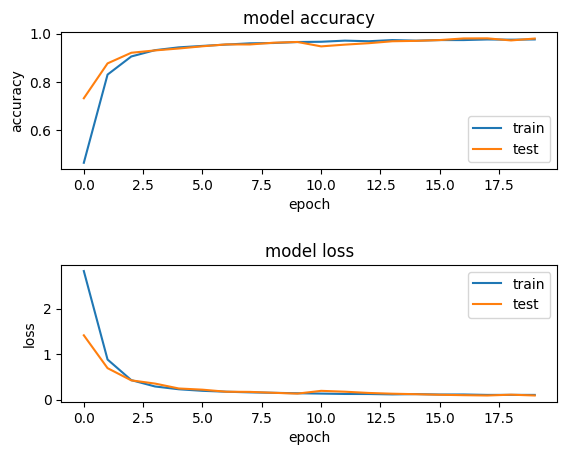

Final Test Accuracy: 0.9859954118728638


In [ ]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [ ]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


ValueError: in user code:

    File "c:\Python\Pyhton3.10.0\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "c:\Python\Pyhton3.10.0\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python\Pyhton3.10.0\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Python\Pyhton3.10.0\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "c:\Python\Pyhton3.10.0\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Python\Pyhton3.10.0\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_91" is incompatible with the layer: expected shape=(None, 19), found shape=(None, 20)


In [ ]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              328        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True
